In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import re
import tqdm
import time
import sys
import ast
import json
import scipy
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from typing import List, Dict
from data.make_data import get_links, is_article, save_links, extract_links, get_date_from_url, extract_links_main

sys.path.append('../hot_links')
# TODO Something like this in dataset.py
# from hot_links.config import PROCESSED_DATA_DIR, RAW_DATA_DIR

from hot_links.vector_db_utils import *

np.random.seed(41)
logger = logging.getLogger(__name__)


ModuleNotFoundError: No module named 'seaborn'

In [10]:
vs_name = 'hot_links'

vector_store_id = get_vector_store_id(vs_name = vs_name)

if not vector_store_id:
    print('Creating...')
    logger.info('Creating vs {vs_name}')
    vector_store_id = create_vs(vs_name)
    
logger.info('Set up {vs_name}')

In [4]:
df_seed = pd.read_csv('../data/processed/seed.csv')
## Assumes you haven't done snowballing

In [6]:
df_seed['links'] = df_seed['links'].apply(ast.literal_eval)

In [81]:
test_article = df_seed.iloc[5,:]

In [82]:
test_article_links = [d['href']+'.txt' for d in test_article['links']]
test_article_snippets = [d['link'] for d in test_article['links']]

## Just search for content of document

In [91]:
def get_matched_links(query,test_article,test_article_links,results, v = False):

    results = client.vector_stores.search(
    vector_store_id=vector_store_id,
    query=query[:4096],
    max_num_results = 20
    )
    
    test_article_links = [d['href']+'.txt' for d in test_article['links']]
    test_article_snippets = [d['link'] for d in test_article['links']]
    
    results = results.data

    matched_chunk_filesnames = []
    matched_chunk_positions = []

    for n,r in enumerate(results):
        #print(r.filename,r.score)
        
        if r.filename in test_article_links:
            if v:print('Match')
            if v:print(r.filename,r.score)
            if not r.filename in matched_chunk_filesnames:
                # Don't duplicate matched chunks
                matched_chunk_filesnames.append(r.filename)
                matched_chunk_positions.append(n)
    matched_chunk_filesnames = list(set(matched_chunk_filesnames))
    if v:print('-------')
    if v:print('Out of {:d} article links, {:d} were returned within the {:d} results (after excluding seed article)'.format(len(test_article_links),len(matched_chunk_filesnames),len(results)))
    
    return matched_chunk_filesnames,matched_chunk_positions, len(matched_chunk_filesnames)

In [97]:
query = test_article['bodyContent'][:4096]

In [98]:
names, ranks, total = get_matched_links(query,test_article,test_article_links,results, v = False)

In [99]:
names, ranks,total

(['https://www.theguardian.com/commentisfree/2015/jul/31/money-made-cricket-poorer-ashes-rooten-state-governance.txt'],
 [1],
 1)

In [116]:
n_eval = 20

all_names, all_ranks, all_totals, all_true_totals = [],[],[],[]

for row in tqdm.tqdm(df_seed.sample(n_eval).iterrows()):
    query = str(row[1]['bodyContent'])[:4096]
    
    names, ranks, total = get_matched_links(query,row[1],test_article_links,results, v = False)
    
    all_names.append(names)
    all_ranks.append(ranks)
    all_totals.append(total)
    all_true_totals.append(len(test_article_links))

0it [00:00, ?it/s]

20it [00:35,  1.76s/it]


In [117]:
n_zero_matches = len(list(filter(lambda x:len(x)==0, all_ranks)))

print('{:d} articles have no link matches ({:.2f})'.format(n_zero_matches,100* (n_zero_matches/float(n_eval))))

12 articles have no link matches (60.00)


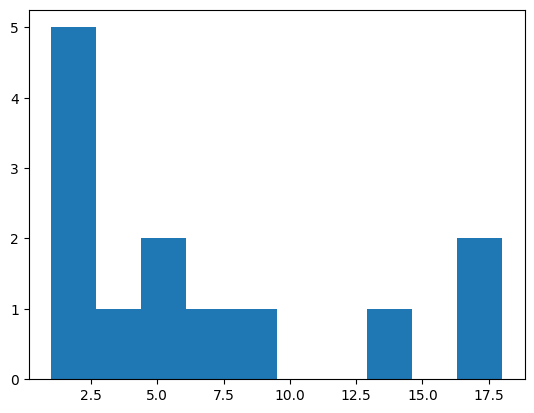

In [118]:
_ = plt.hist([item for sublist in all_ranks for item in sublist])
#item['href'] for sublist in all_article_links for item in sublist

## Search for specific snippet

In [32]:
n_test = 2
# Which link number in article to test

In [33]:
query = 'I want to add a link at this point\n\
{:s}\n \
in the article below. Which document would be best?\n\
    {:s}'.format(test_article_snippets[n_test],test_article['bodyContent'][:4096])

In [34]:
results = client.vector_stores.search(
    vector_store_id=vector_store_id,
    query=query[:4096],
    max_num_results = 20
)

In [35]:
results =[r for r in results if not r.filename == test_article.webUrl+'.txt']
# Drop original article from results

In [36]:
print(test_article_snippets[n_test])
print(test_article_links[n_test])

Chris Kermode of the ATP on the subject of match-fixing
https://www.theguardian.com/sport/2016/jan/18/tennis-match-fixing-claims-authorities-absolutely-reject-any-cover-up.txt


In [37]:
for n,r in enumerate(results):
    #print(r.filename)
    #print('Score: {:.2f}'.format(r.score))
    #print()

    if r.filename == test_article_links[n_test]:
        print('-----')
        print('Matched at',n)
        print('Score: {:.2f}'.format(r.score))
        print(r.filename)
        print(test_article_snippets[n_test])
        print(test_article_links[n_test])
        print('-----')

-----
Matched at 5
Score: 0.50
https://www.theguardian.com/sport/2016/jan/18/tennis-match-fixing-claims-authorities-absolutely-reject-any-cover-up.txt
Chris Kermode of the ATP on the subject of match-fixing
https://www.theguardian.com/sport/2016/jan/18/tennis-match-fixing-claims-authorities-absolutely-reject-any-cover-up.txt
-----
